# Creating input GeoJson for Nguenyyiel Refugee Camp

This notebook is intended to generate the input data for the **Nguenyyiel** refugee camp to subsequently be able to apply our model. We use data from OpenStreetMap and identify the current buildings, roads, and both potential and existing healthcare facilities. 
The goal is to:
- Identify **demand points** using building centroids.
- Generate **candidate sites** for new **Health Centers (HCs)** and **Health Posts (HPs)** near existing roads.
- Situate **existing facilities** based on coordinates send by CUAMM.
- Plot the results with categorized elements.
- Create a **GeoJson** file with all the above information.

### 1. Import Required Libraries

In [299]:
import osmnx as ox
import geopandas as gpd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import json
from shapely.geometry import Point, MultiPoint

### 2. Load Spatial Data from OpenStreetMap

We extract:
- **Area boundary** (`area`)
- **Buildings** (`buildings`)
- **Roads** (`roads`)

In [300]:
# Specify the location name
place_name = "Nguenyyiel"

# Get area boundary as a GeoDataFrame
area = ox.geocode_to_gdf(place_name)

# Extract buildings and roads from OSM
buildings = ox.features_from_place(place_name, tags={'building': 'yes'})
roads = ox.features_from_place(place_name, tags={'surface': 'unpaved'})

# Existing health_center is also identified in OSM as a 'hospital'
# health_center = ox.features_from_place(place_name, tags={'amenity': 'hospital'})


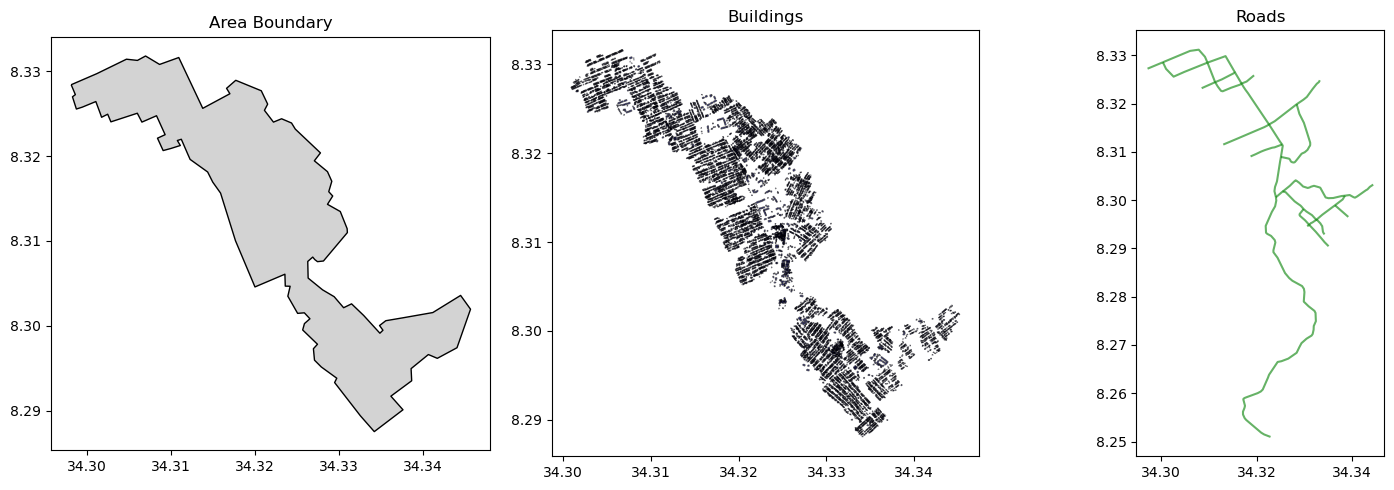

In [301]:
# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 3 side-by-side plots

# Plot each dataset separately
area.plot(ax=axes[0], color="lightgray", edgecolor="black")
axes[0].set_title("Area Boundary")

buildings.plot(ax=axes[1], color="blue", alpha=0.6, edgecolor="black")
axes[1].set_title("Buildings")

roads.plot(ax=axes[2], color="green", alpha=0.6)
axes[2].set_title("Roads")

# Show the plots
plt.tight_layout()
plt.show()

### 3. Load Existing Health Facilities

- **Existing Health Center (HC)**: Provided coordinates for the HC at Zone C
- **Existing Health Posts (HPs)**: Provided coordinates for the HPs at Zones A & D

In [302]:
# Define existing HC (Health Center)
existing_hc = gpd.GeoDataFrame(geometry=[Point(34.325258, 8.3053)], crs="EPSG:4326")

# Define existing HPs (Health Posts)
existing_hps = gpd.GeoDataFrame(
    {
        "name": ["existing_hp_A", "existing_hp_D"],
        "geometry": [Point(34.311944, 8.323889), Point(34.320833, 8.319722)]
    },
    crs="EPSG:4326"
)

### 4. Process Buildings: Compute Centroids & Filter Valid Demand Points

1. **Reproject buildings** to a projected CRS (EPSG:3395 - meters-based)
2. **Compute centroids** of buildings (which are currently recognize as polygons)
3. **Filter centroids** to exclude existing facilities

In [303]:
# Reproject buildings to EPSG:3395
buildings_projected = buildings.to_crs(epsg=3395)

# Compute centroids
buildings_projected["centroid"] = buildings_projected.geometry.centroid
centroid_coords = buildings_projected["centroid"].apply(lambda geom: (geom.x, geom.y))

# Combine existing health facilities
existing_facilities = MultiPoint([*existing_hc.geometry, *existing_hps.geometry])

# Function to filter valid centroids
def filter_valid_centroids(centroid_coords, existing_facilities):
    return [Point(c) for c in centroid_coords if not existing_facilities.intersects(Point(c))]

# Get valid centroids
valid_centroids = filter_valid_centroids(centroid_coords, existing_facilities)


### 5. Generate Demand Points using KMeans Clustering

We consider the centroids of the 13,564 buildings and cluster them into 200 "population zones" (which will be our demand points)
- **Clusters:** 200
- **Method:** KMeans
- **Goal:** Assign each demand point to a cluster

In [304]:
# Set seeds for reproducibility
random.seed(30)
np.random.seed(30)

# Perform KMeans clustering on valid centroids
kmeans = KMeans(n_clusters=200, random_state=30)
valid_centroids_coords = np.array([p.coords[0] for p in valid_centroids])
kmeans.fit(valid_centroids_coords)

KMeans(n_clusters=200, random_state=30)

### 6. Generate Candidate Sites for New Facilities Near Roads

1. **Reproject roads**
2. **Buffer roads** (100m) to find nearby spaces
3. **Avoid existing facilities**

In [305]:
# Reproject both roads and area to EPSG:3395
roads_projected = roads.to_crs(epsg=3395)
area_projected = area.to_crs(epsg=3395)  # Ensure area is in the same CRS

# Clip roads within the area boundary
roads_clipped = gpd.clip(roads_projected, area_projected)

# Create buffer (100m around roads)
buffer_distance = 100
road_buffer = roads_clipped.buffer(buffer_distance)

# Extract candidate sites near roads
road_candidate_sites = [poly.representative_point() for poly in road_buffer if not existing_facilities.intersects(poly)]

# Shuffle candidate sites for randomness
random.shuffle(road_candidate_sites)

# Select 8 HPs and 6 HCs
new_hp_sites = road_candidate_sites[:8]
new_hc_sites = road_candidate_sites[8:14]

### 7. Reproject Existing Facilities to Match EPSG:3395


In [306]:
existing_hc_projected = existing_hc.to_crs(epsg=3395)
existing_hps_projected = existing_hps.to_crs(epsg=3395)

### 8. Plot the Results with Custom Legend


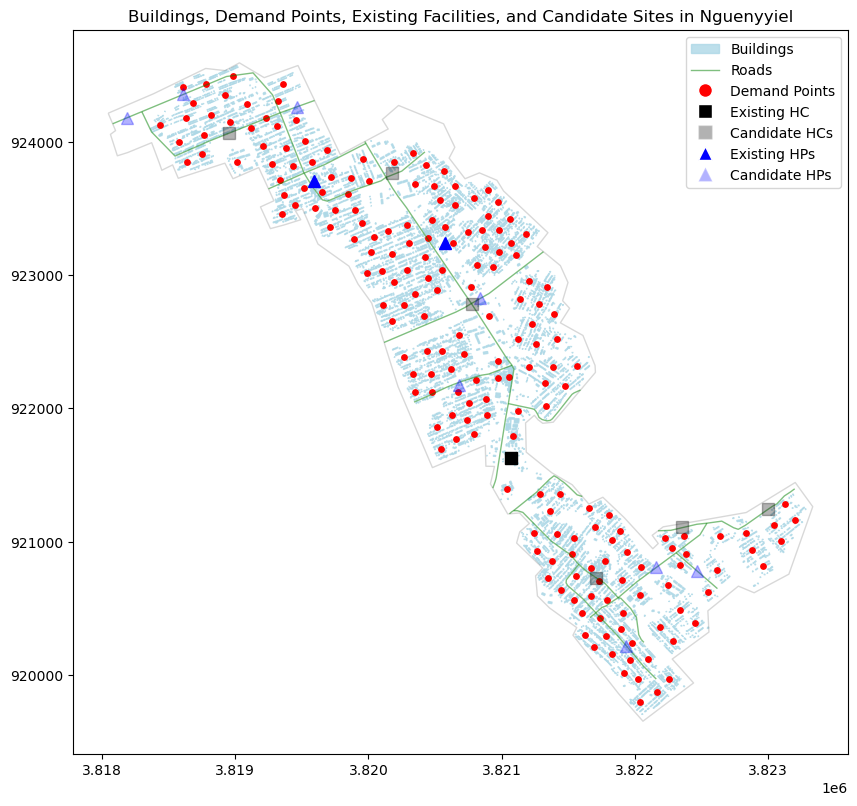

In [ ]:
# Create figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot buildings
buildings_projected.plot(ax=ax, color="lightblue", alpha=0.8, edgecolor="lightblue")

# Plot roads
roads_clipped.plot(ax=ax, color="green", alpha=0.5, linewidth=1)

# Plot demand points
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color="red", marker="o", s=15)

# Plot candidate HPs and HCs
for hp in new_hp_sites:
    ax.plot(hp.x, hp.y, '^', color='blue', alpha=0.3, markersize=8)  # Blue triangle
for hc in new_hc_sites:
    ax.plot(hc.x, hc.y, 's', color='black', alpha=0.3, markersize=8)  # Black square

# Plot existing HC
ax.plot(existing_hc_projected.iloc[0].geometry.x, existing_hc_projected.iloc[0].geometry.y, 's', color='black', markersize=8)

# Plot existing HPs
ax.plot(existing_hps_projected.geometry.x, existing_hps_projected.geometry.y, '^', color='blue', markersize=8)


# Plot the boundary of the area (outline only)
area_projected.plot(ax=ax, edgecolor="gray", alpha=0.3, linewidth=1, facecolor="none")

# Define legend elements
building_patch = mpatches.Patch(color="lightblue", alpha=0.8, label="Buildings")
road_patch = mlines.Line2D([], [], color='green', alpha=0.5, linewidth=1, label="Roads")
demand_patch = mlines.Line2D([], [], marker='o', color='w', markerfacecolor='red', markersize=10, label="Demand Points")
existing_hc_patch = mlines.Line2D([], [], marker='s', color='w', markerfacecolor='black', markersize=10, label="Existing HC")
candidate_hcs_patch = mlines.Line2D([], [], marker='s', color='w', markerfacecolor='black', alpha=0.3, markersize=10, label="Candidate HCs")
existing_hps_patch = mlines.Line2D([], [], marker='^', color='w', markerfacecolor='blue', markersize=10, label="Existing HPs")
candidate_hps_patch = mlines.Line2D([], [], marker='^', color='w', markerfacecolor='blue', alpha=0.3, markersize=10, label="Candidate HPs")

# Add legend
plt.legend(handles=[building_patch, road_patch, demand_patch, existing_hc_patch, candidate_hcs_patch, existing_hps_patch, candidate_hps_patch])
plt.title(f"Buildings, Demand Points, Existing Facilities, and Candidate Sites in {place_name}")

#plt.savefig("nguenyyiel.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()





### 9. Convert Data for GeoJSON Export
This section builds on the previous analysis by:
1. Converting demand points, candidate facilities, and existing facilities to EPSG:4326
2. Structuring all data into a **GeoJSON format**
3. Exporting the data for further use

#### 9.1. Convert Demand Points (KMeans Centroids) to EPSG:4326
- The demand points are already clustered (`kmeans.cluster_centers_`)
- Convert them to **latitude/longitude**

In [286]:
# Convert demand points (KMeans centroids) to GeoDataFrame
gdf_demand = gpd.GeoDataFrame(
    geometry=[Point(x, y) for x, y in kmeans.cluster_centers_],
    crs="EPSG:3395"
).to_crs("EPSG:4326")

# Extract lat/lon coordinates
demand_centroids_latlon = gdf_demand.geometry.apply(lambda point: [point.x, point.y]).tolist()



#### 9.2. Convert Candidate HP and HC Locations to EPSG:4326
- These points were previously selected near roads (`new_hp_sites` and `new_hc_sites`)
- Convert them to **latitude/longitude**

In [287]:
# Convert HP candidates to GeoDataFrame
gdf_new_hp_sites = gpd.GeoDataFrame(geometry=new_hp_sites, crs="EPSG:3395").to_crs("EPSG:4326")

new_hp_sites_latlon = gdf_new_hp_sites.geometry.apply(lambda point: [point.x, point.y]).tolist()

# Convert HC candidates to GeoDataFrame
gdf_new_hc_sites = gpd.GeoDataFrame(geometry=new_hc_sites, crs="EPSG:3395").to_crs("EPSG:4326")

new_hc_sites_latlon = gdf_new_hc_sites.geometry.apply(lambda point: [point.x, point.y]).tolist()

### 9.3. Convert Existing Facilities to EPSG:4326
- The **existing health center (HC)**
- The **existing health posts (HPs)**
- Assign **custom names** for better identification

In [288]:
# Convert Existing HC (already in EPSG:3395, reproject it)
existing_hc_projected = existing_hc.to_crs("EPSG:4326")
existing_hc_latlon = [existing_hc_projected.iloc[0].geometry.x, existing_hc_projected.iloc[0].geometry.y]

# Convert Existing HPs
existing_hps_projected = existing_hps.to_crs("EPSG:4326")
existing_hps_latlon = existing_hps_projected.geometry.apply(lambda point: [point.x, point.y]).tolist()

# Assign custom names for existing facilities
existing_facilities = [
    {"type": "HC", "name": "HC_ExistingLocationC", "coords": existing_hc_latlon},
    {"type": "HP", "name": "HP_ExistingLocationD", "coords": existing_hps_latlon[0]},
    {"type": "HP", "name": "HP_ExistingLocationA", "coords": existing_hps_latlon[1]}
]

### 9.4. Generate GeoJSON Features
We create a **GeoJSON structure** for:
1. Demand points
2. Candidate HP locations
3. Candidate HC locations
4. Existing facilities

In [289]:
# Initialize an empty list to store features
features = []

# Demand Points
for i, centroid in enumerate(demand_centroids_latlon):
    feature = {
        "type": "Feature",
        "properties": {
            "Name": f"Nguenyyiel{i+1}", 
            "Camp": "Nguenyyiel", 
            "type_f": "demand_point"
        },
        "geometry": {
            "type": "Point",
            "coordinates": centroid  # [Longitude, Latitude]
        }
    }
    features.append(feature)

# Candidate sites for HPs
for i, hp in enumerate(new_hp_sites_latlon):
    feature = {
        "type": "Feature",
        "properties": {
            "Name": f"HP_CandidateLocation{i+1}",
            "Camp": "Nguenyyiel",
            "type_f": "HP"
        },
        "geometry": {
            "type": "Point",
            "coordinates": hp
        }
    }
    features.append(feature)

# Candidate sites for HCs
for i, hc in enumerate(new_hc_sites_latlon):
    feature = {
        "type": "Feature",
        "properties": {
            "Name": f"HC_CandidateLocation{i+1}",
            "Camp": "Nguenyyiel",
            "type_f": "HC"
        },
        "geometry": {
            "type": "Point",
            "coordinates": hc
        }
    }
    features.append(feature)

# Existing Facilities (Custom Names)
for facility in existing_facilities:
    feature = {
        "type": "Feature",
        "properties": {
            "Name": facility["name"],
            "Camp": "Nguenyyiel",
            "type_f": facility["type"]
        },
        "geometry": {
            "type": "Point",
            "coordinates": facility["coords"]
        }
    }
    features.append(feature)

### 9.5. Create Final GeoJSON Structure


In [290]:
geojson = {
    "type": "FeatureCollection",
    "name": "location_nguenyyiel",
    "features": features
}

# Uncomment this block to save the GeoJSON file
with open("nguenyyiel_baseline.geojson", "w") as f:
    json.dump(geojson, f)

print("GeoJSON file created: nguenyyiel_baseline.geojson")


GeoJSON file created: nguenyyiel_baseline.geojson


In [293]:
print(gdf.head())  # Preview the first few rows


          Name        Camp        type_f                  geometry
0  Nguenyyiel1  Nguenyyiel  demand_point  POINT (34.32649 8.31716)
1  Nguenyyiel2  Nguenyyiel  demand_point   POINT (34.32866 8.2964)
2  Nguenyyiel3  Nguenyyiel  demand_point  POINT (34.31006 8.32614)
3  Nguenyyiel4  Nguenyyiel  demand_point  POINT (34.31804 8.31556)
4  Nguenyyiel5  Nguenyyiel  demand_point  POINT (34.33447 8.29181)


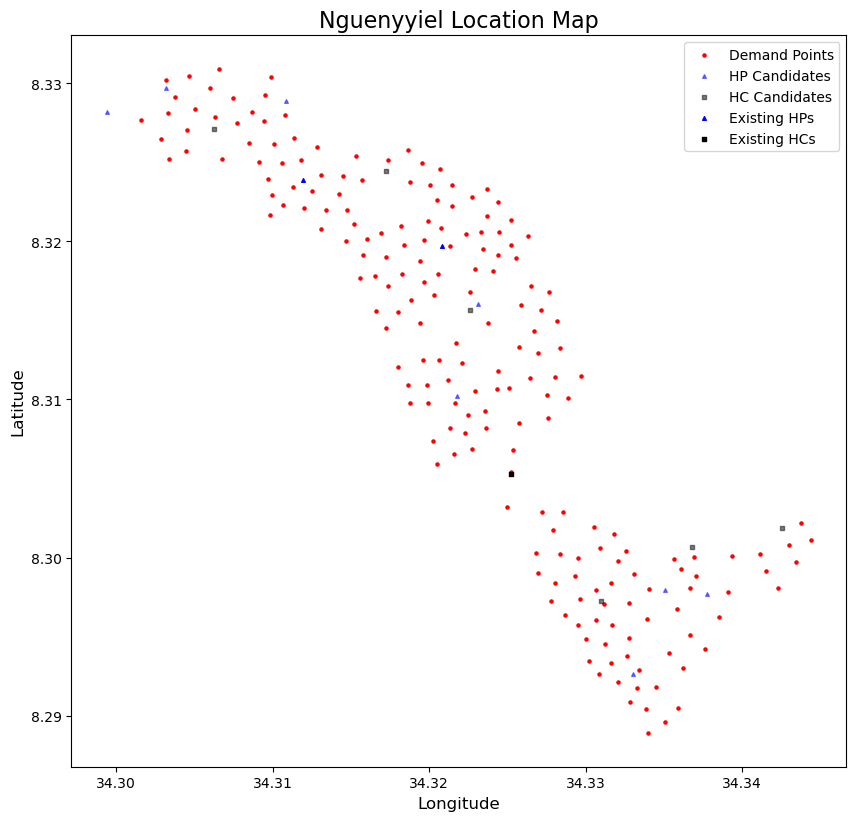

In [297]:

# Read the GeoJSON file
geojson_file = "nguenyyiel_baseline.geojson"
gdf = gpd.read_file(geojson_file)

# Plot the GeoDataFrame, distinguishing by feature type
fig, ax = plt.subplots(figsize=(10, 10))

# Plot demand points
demand_points = gdf[gdf['type_f'] == 'demand_point']
demand_points.plot(ax=ax, marker='o', color='red', label='Demand Points', markersize=5)

# Plot HP candidates
hp_candidates = gdf[(gdf['type_f'] == 'HP') & (gdf['Name'].str.contains('Candidate'))]
hp_candidates.plot(ax=ax, marker='^', color='blue', alpha=0.5, label='HP Candidates', markersize=7)

# Plot HC candidates
hc_candidates = gdf[(gdf['type_f'] == 'HC') & (gdf['Name'].str.contains('Candidate'))]
hc_candidates.plot(ax=ax, marker='s', color='black', alpha=0.5, label='HC Candidates', markersize=7)

# Plot existing facilities (both HP and HC)
existing_hp = gdf[(gdf['type_f'] == 'HP') & (gdf['Name'].str.contains('Existing'))]
existing_hp.plot(ax=ax, marker='^', color='blue', label='Existing HPs', markersize=7)

existing_hc = gdf[(gdf['type_f'] == 'HC') & (gdf['Name'].str.contains('Existing'))]
existing_hc.plot(ax=ax, marker='s', color='black', label='Existing HCs', markersize=7)

# Customize plot
ax.set_title('Nguenyyiel Location Map', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.legend(loc='upper right')
plt.show()
